<a href="https://colab.research.google.com/github/KImre28/ls_data/blob/main/ls_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of the gathered data

## Importing packages

In [ ]:
import numpy as np
import pandas as pd
import datetime
import math
from scipy import stats
from scipy.stats import pearsonr
import matplotlib.dates as md
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot as plt
import seaborn as sn
from functools import reduce

import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import matplotlib.mlab as mlab

## Importing dataframes
- 1 hour resolution neutron monitor data for 1/12/1981 - 10/7/2023
- 1 minute resolution neutron monitor data for 1/1/2001 - 10/7/2023
- 1 hour resolution F10.7 and DST data from OMNI data set for 1/12/1981 - 10/7/2023

In [ ]:
# 'nm' stands for 'Neutron Monitor'
# 'h' stands for 'hourly averages'
# 'm' stands for 'minutely averages'
# 'df' stands for 'dataframe'
nm_hdf = pd.read_parquet('/content/sample_data/LMKS_NM_1981-2023_hour.parquet.gzip')
#nm_mdf = pd.read_parquet('/content/sample_data/LMKS_NM_2001-2023_min.parquet.gzip')
omni = pd.read_parquet('/content/sample_data/f10-dst_1981-2023_hour.parquet.gzip')

### Creating a unified dataframe for 1 hour resolution data

In [ ]:
# 'mdf' stands for 'main dataframe'
# 'h' stands for hourly averages
mdfh = pd.concat([nm_hdf, omni], axis=1)
#mdfh['nm_avg'] = mdfh['H_COR'].rolling(window=720).mean()
#mdfh['f10_avg'] = mdfh['F10_INDEX'].rolling(window=720).mean()
#mdfh['dst_avg'] = mdfh['DST'].rolling(window=720).mean()
mdfh
#mdfh = mdfh.iloc[:,col].rolling(window=5).mean()

,H_COR,w,F10_INDEX,DST
1981-12-01 00:00:00,87.2680,,230.699997,4
1981-12-01 01:00:00,86.9240,,230.699997,5
1981-12-01 02:00:00,86.8670,,230.699997,6
1981-12-01 03:00:00,86.4080,,230.699997,7
1981-12-01 04:00:00,86.5230,,230.699997,8
...,...,...,...,...
2023-07-10 19:00:00,92.4196,,196.899994,-3
2023-07-10 20:00:00,92.4196,,196.899994,2
2023-07-10 21:00:00,92.4196,,196.899994,5
2023-07-10 22:00:00,92.4196,,196.899994,6


### A quick view of data in main dataframe

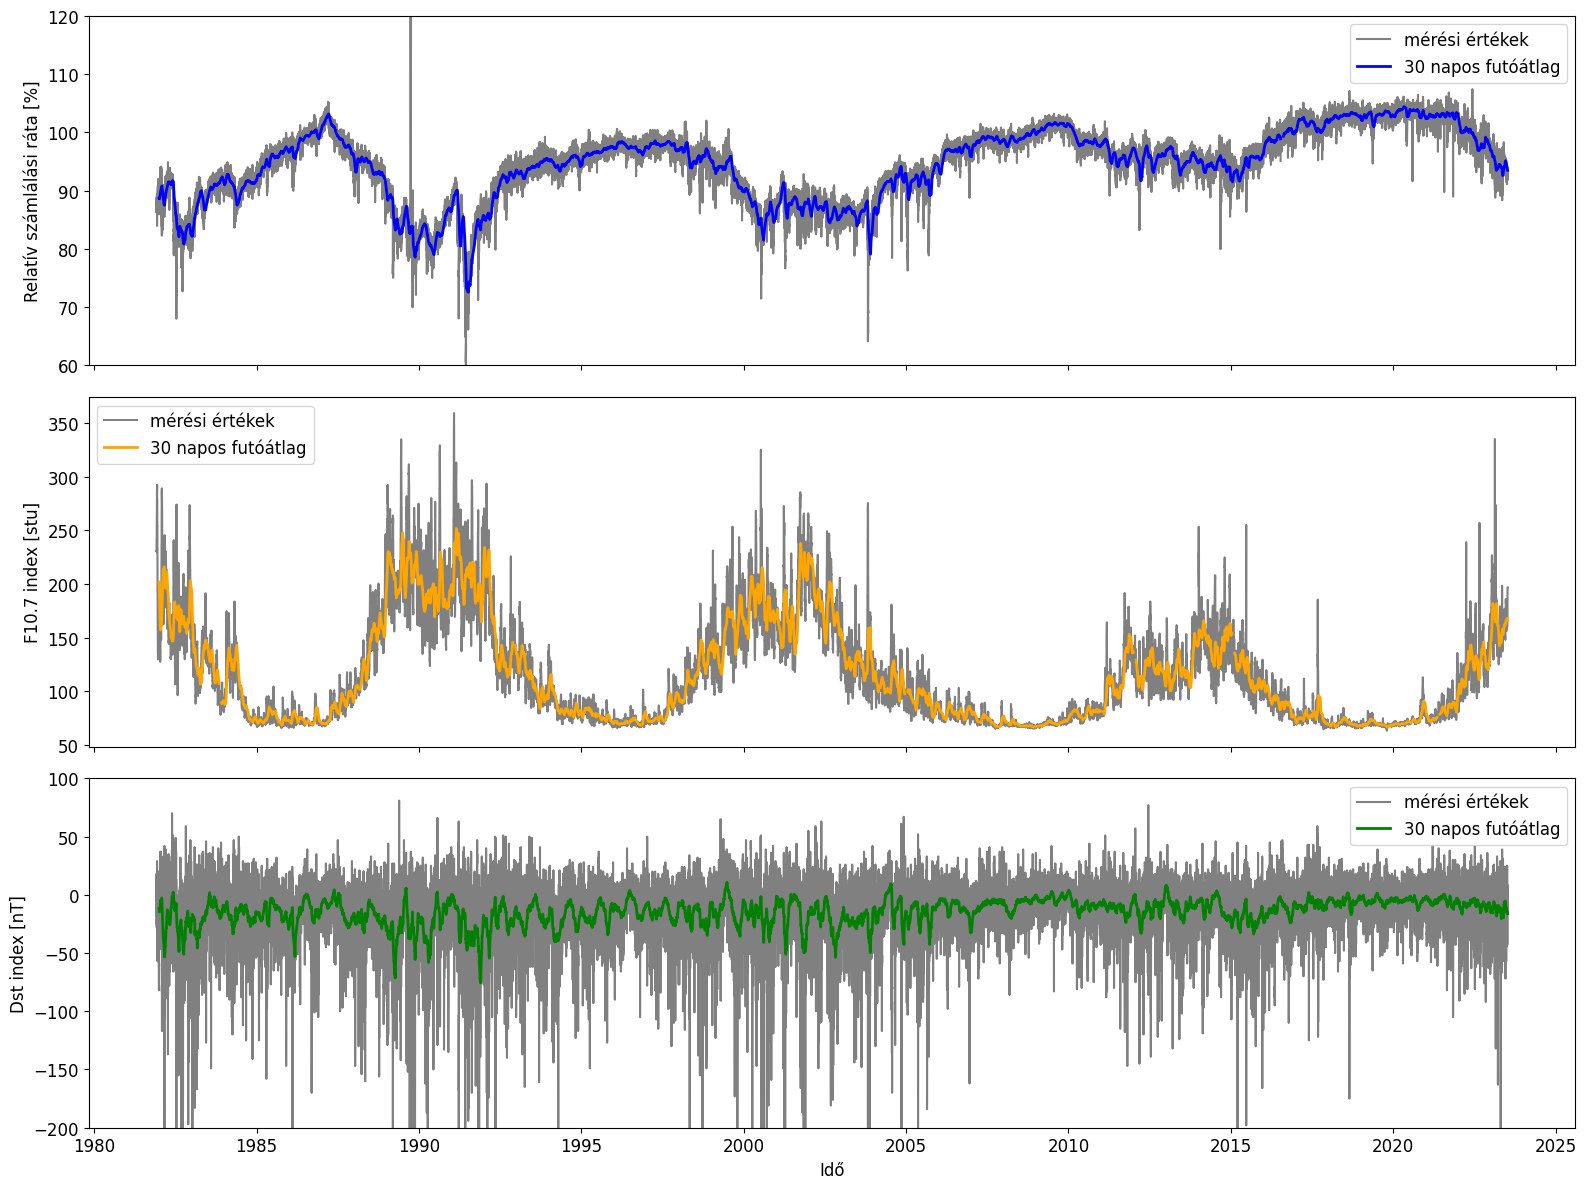

In [ ]:
#mdfh.plot(y=['H_COR', 'value_24hr_avg'], subplots=True, figsize=(20,15))
#nm_mdf.plot(subplots=True, figsize=(20,5))
#plt.show()
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

axes[0].plot(mdfh['H_COR'], label='mérési értékek', color='grey', linewidth=1.5)
axes[0].plot(mdfh['nm_avg'], label='30 napos futóátlag', color='blue', linewidth=2.0)
axes[0].legend(fontsize='large')
axes[0].set_ylabel('Relatív számlálási ráta [%]', fontsize='large')
axes[0].tick_params(axis='both', which='both', labelsize='large')
axes[0].set_ylim([60, 120])

axes[1].plot(mdfh['F10_INDEX'], label='mérési értékek', color='grey', linewidth=1.5)
axes[1].plot(mdfh['f10_avg'], label='30 napos futóátlag', color='orange', linewidth=2.0)
axes[1].legend(fontsize='large')
axes[1].set_ylabel('F10.7 index [stu]', fontsize='large')
axes[1].tick_params(axis='both', which='both', labelsize='large')

axes[2].plot(mdfh['DST'], label='mérési értékek', color='grey', linewidth=1.5)
axes[2].plot(mdfh['dst_avg'], label='30 napos futóátlag', color='green', linewidth=2.0)
axes[2].legend(fontsize='large')
axes[2].set_xlabel('Idő', fontsize='large')
axes[2].set_ylabel('Dst index [nT]', fontsize='large')
axes[2].tick_params(axis='both', which='both', labelsize='large')
axes[2].set_ylim([-200, 100])


plt.tight_layout()
plt.show()

In [ ]:
# provide overall characteristics of the 1 hour resolution NM data frame
mdfh.describe()

,H_COR,F10_INDEX,DST,nm_avg,f10_avg,dst_avg
count,364704.000000,364416.000000,364728.00000,363266.000000,357226.000000,364009.000000
mean,94.506592,114.837822,-14.53995,94.505216,114.946099,-14.543308
std,6.068182,47.853996,22.10731,5.914168,44.746126,10.673129
min,59.889000,63.400002,-589.00000,72.604776,66.776668,-75.700000
25%,90.878769,74.800003,-23.00000,91.078830,75.766354,-20.470833
50%,95.576000,99.099998,-10.00000,95.491234,101.950001,-12.300000
75%,98.739000,142.199997,-1.00000,98.593092,142.931251,-6.620833
max,220.656000,359.200012,81.00000,104.400382,251.766665,10.551389


In [ ]:
mdfh['w'] = pd.to_numeric(mdfh['w'], errors='coerce')
mdfh = mdfh.drop(mdfh.columns[1], axis=1)
print(mdfh.dtypes)
# provide overall characteristics of the 1 minute resolution NM data frame
#nm_mdf.describe()

H_COR        float64
F10_INDEX    float32
DST            int32
dtype: object


# Searching for linear correlations in data

In [ ]:
columns = mdfh.columns
correlation_matrix = pd.DataFrame(index=columns, columns=columns)
p_values_matrix = pd.DataFrame(index=columns, columns=columns)
for col1 in columns:
    for col2 in columns:
        mask = ~mdfh[col1].isna() & ~mdfh[col2].isna() & ~mdfh[col1].isin([np.inf, -np.inf]) & ~mdfh[col2].isin([np.inf, -np.inf])
        corr_coeff, p_value = pearsonr(mdfh[col1][mask], mdfh[col2][mask])
        correlation_matrix.loc[col1, col2] = corr_coeff
        p_values_matrix.loc[col1, col2] = p_value

        print(correlation_matrix)
        print("\nP-values Matrix:")
        print(f"{p_values_matrix}")

# basic Pearson analysis (checks if the values of timeseries A change in the same direction and with the same magnitude as the values of timeseries B do)
#the results will range from -1 to 1, 1 indicating identical datasets, -1 indicating perfect anticorrelation

          H_COR F10_INDEX  DST
H_COR       1.0       NaN  NaN
F10_INDEX   NaN       NaN  NaN
DST         NaN       NaN  NaN

P-values Matrix:
          H_COR F10_INDEX  DST
H_COR       0.0       NaN  NaN
F10_INDEX   NaN       NaN  NaN
DST         NaN       NaN  NaN
          H_COR F10_INDEX  DST
H_COR       1.0  -0.74212  NaN
F10_INDEX   NaN       NaN  NaN
DST         NaN       NaN  NaN

P-values Matrix:
          H_COR F10_INDEX  DST
H_COR       0.0       0.0  NaN
F10_INDEX   NaN       NaN  NaN
DST         NaN       NaN  NaN
          H_COR F10_INDEX       DST
H_COR       1.0  -0.74212  0.305735
F10_INDEX   NaN       NaN       NaN
DST         NaN       NaN       NaN

P-values Matrix:
          H_COR F10_INDEX  DST
H_COR       0.0       0.0  0.0
F10_INDEX   NaN       NaN  NaN
DST         NaN       NaN  NaN
             H_COR F10_INDEX       DST
H_COR          1.0  -0.74212  0.305735
F10_INDEX -0.74212       NaN       NaN
DST            NaN       NaN       NaN

P-values Matrix:
        

C:\Users\HP Pavilion\AppData\Local\Temp\ipykernel_10572\2053374375.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sn.heatmap(mdfh.corr(method='pearson').iloc[0:1, 1:3])


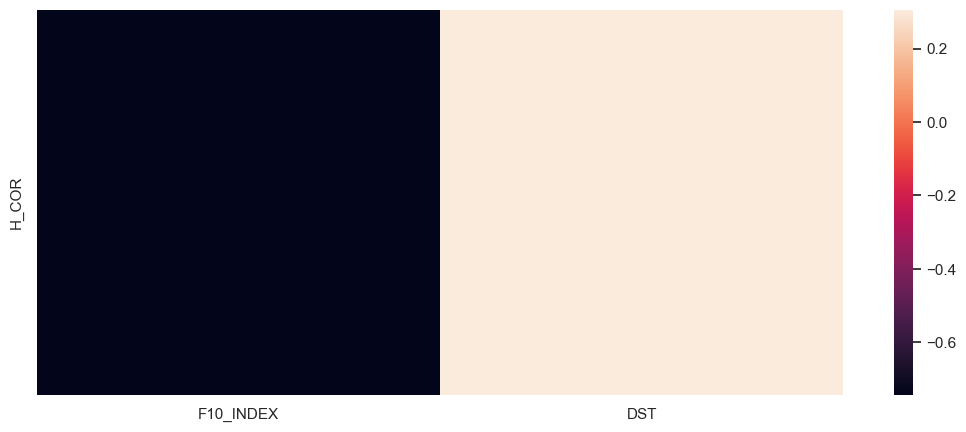

In [ ]:
sn.set(rc = {'figure.figsize':(13,5)})
sn.heatmap(mdfh.corr(method='pearson').iloc[0:1, 1:3])
plt.show()

C:\Users\HP Pavilion\AppData\Local\Temp\ipykernel_10572\1642721989.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sn.heatmap(mdfh.corr(method='pearson'))


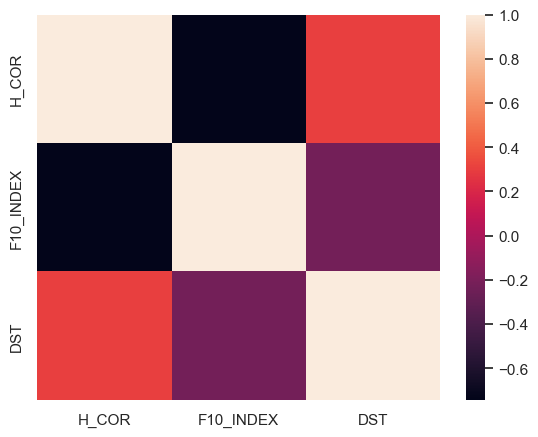

In [ ]:
sn.set(rc = {'figure.figsize':(6.5,5)})
sn.heatmap(mdfh.corr(method='pearson'))
plt.show()

In [ ]:
def polynomial_fit(df_index, df_col, deg):
  '''
  Method to provide least squares polynomial fit of specific column of DF
  :df_index - index of DF
  :df_column - specific column of DF
  : deg - degree of the fitting polynomial
  '''
  x = np.arange(0, len(df_index.values))
  y = df_col.values
  poly_model = np.polyfit(x, y, deg)
  predict = np.poly1d(poly_model)
  return predict(x)

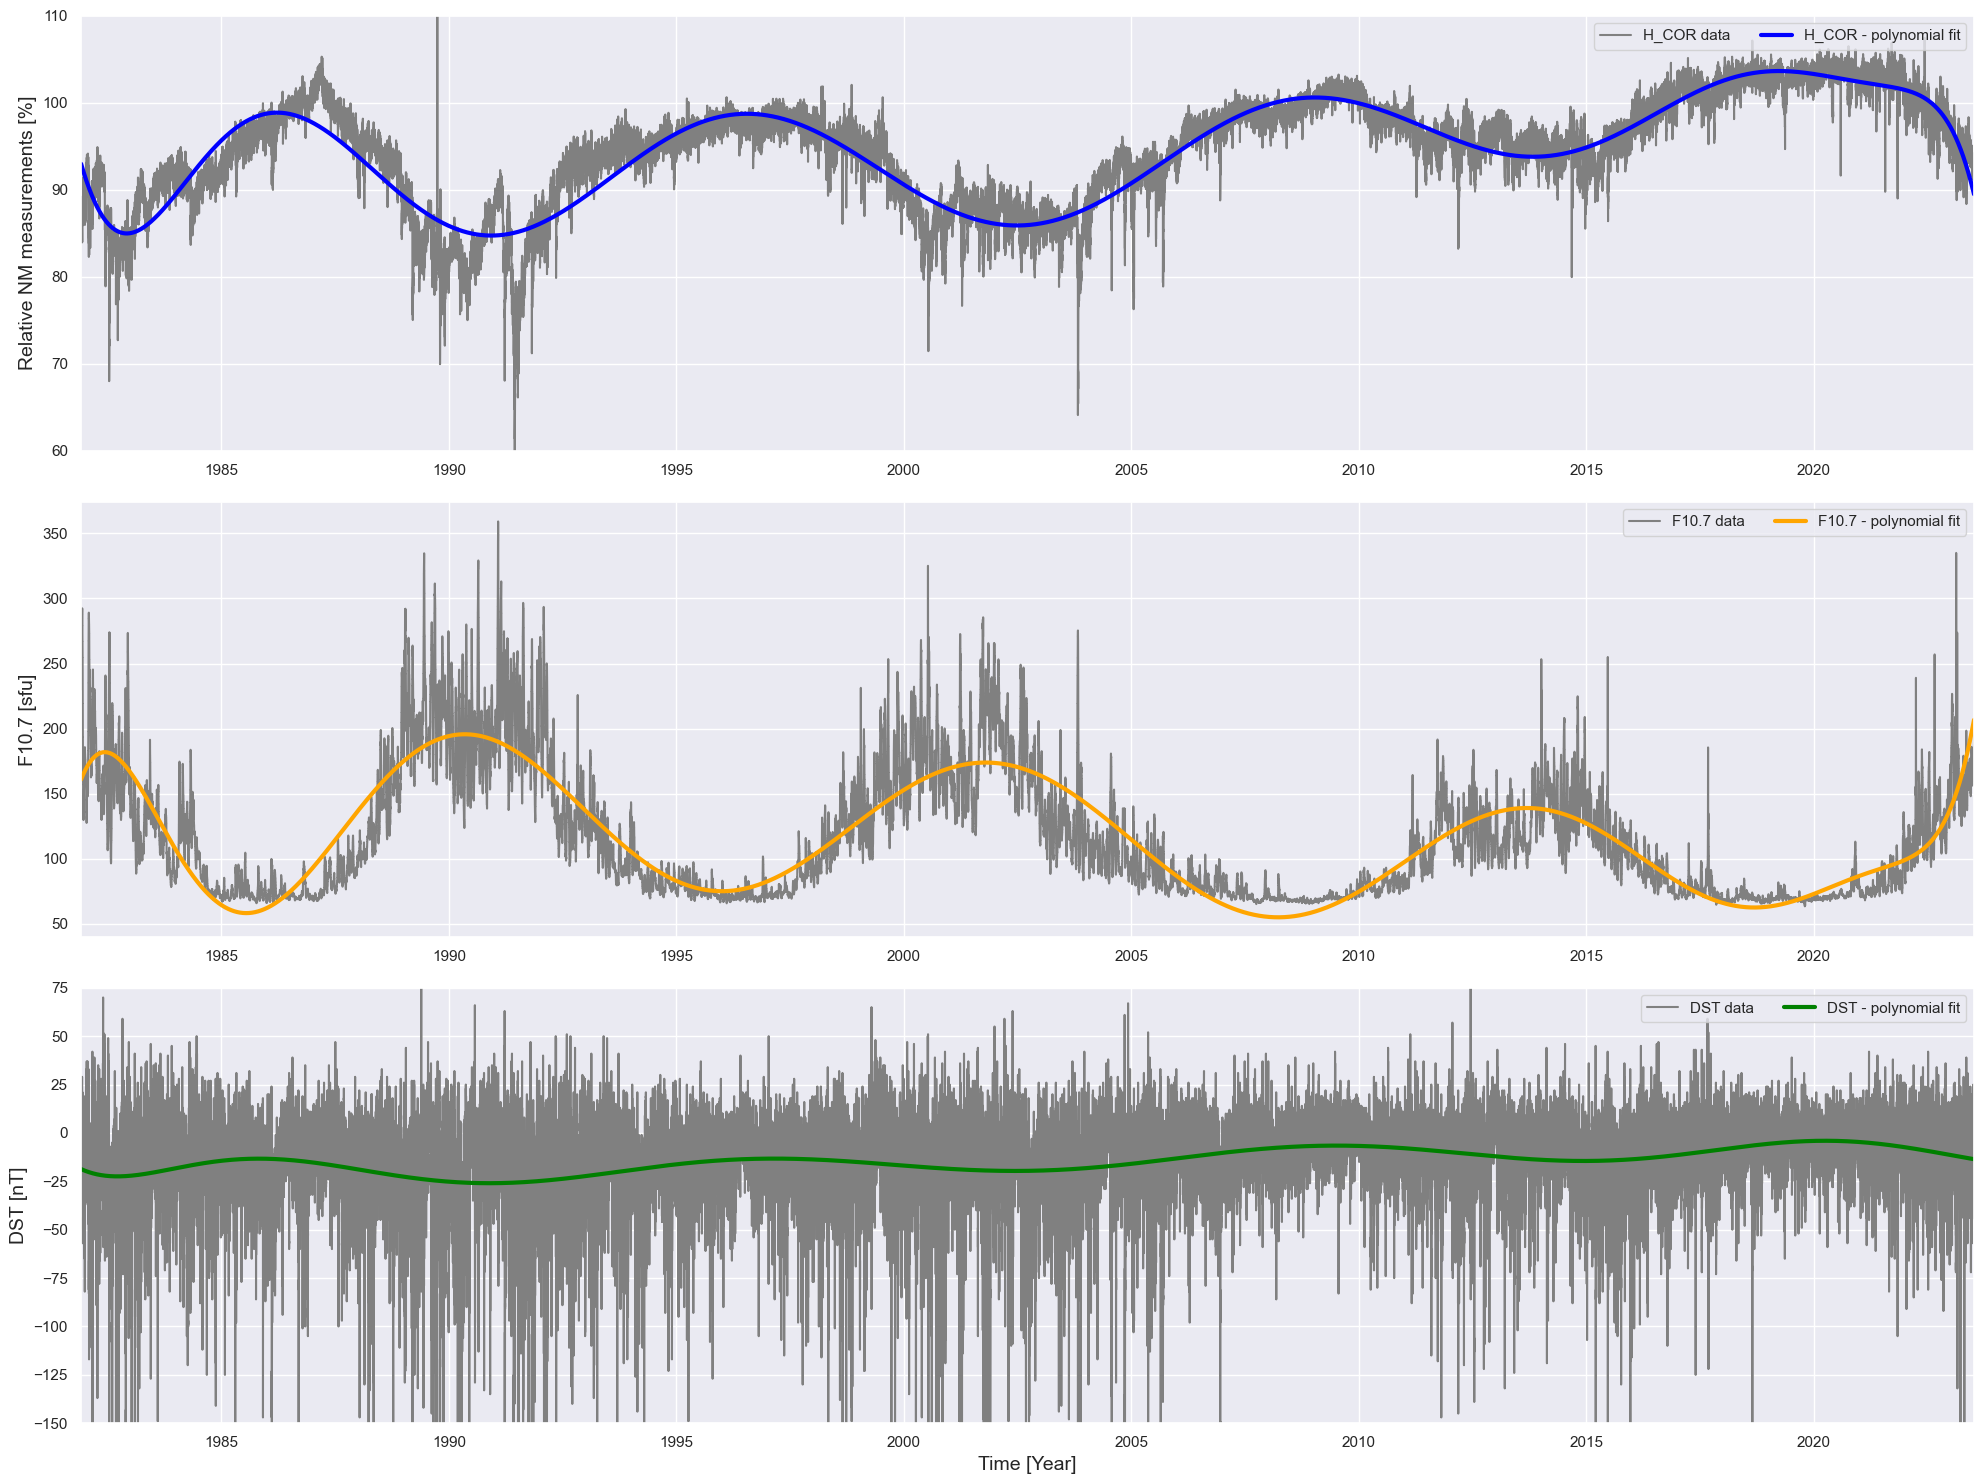

In [ ]:
mdfh['DST'].replace(0, np.NaN, inplace=True)
mdfh.interpolate(method ='linear', limit_direction ='both', inplace=True)

start_year = datetime.datetime.strptime('1981/12/01', "%Y/%m/%d")
end_year = datetime.datetime.strptime('2023/07/10 23:00:00', "%Y/%m/%d %H:%M:%S")

plt.figure(figsize=(10, 6))
plt.subplot(311)
plt.ylabel('Relative NM measurements [%]', fontsize=14)
plt.xlim(start_year, end_year)
plt.ylim(60, 110)
ax=plt.gca()
plt.plot(mdfh.index, mdfh.H_COR, color='gray', label='H_COR data')
plt.plot(mdfh.index, polynomial_fit(mdfh.index, mdfh.H_COR, 12),
         color='blue', label='H_COR - polynomial fit', linewidth=3)
plt.legend(loc='upper right', ncol=2)
plt.subplot(312)
plt.ylabel('F10.7 [sfu]', fontsize=14)
plt.xlim(start_year, end_year)
ax=plt.gca()
plt.plot(mdfh.index, mdfh.F10_INDEX, color='gray', label='F10.7 data')
plt.plot(mdfh.index, polynomial_fit(mdfh.index, mdfh.F10_INDEX, 12),
         color='orange', label='F10.7 - polynomial fit', linewidth=3)
plt.legend(loc='upper right', ncol=2)
plt.subplot(313)
plt.ylabel('DST [nT]', fontsize=14)
plt.xlim(start_year, end_year)
plt.ylim(-150, 75)
ax=plt.gca()
plt.plot(mdfh.index, mdfh.DST, color='gray', label='DST data')
plt.plot(mdfh.index, polynomial_fit(mdfh.index, mdfh.DST, 12),
         color='green', label='DST - polynomial fit', linewidth=3)
plt.legend(loc='upper right', ncol=2)
plt.xlabel('Time [Year]', fontsize=14)
plt.tight_layout()
plt.show()

# Correlation of certain periods only

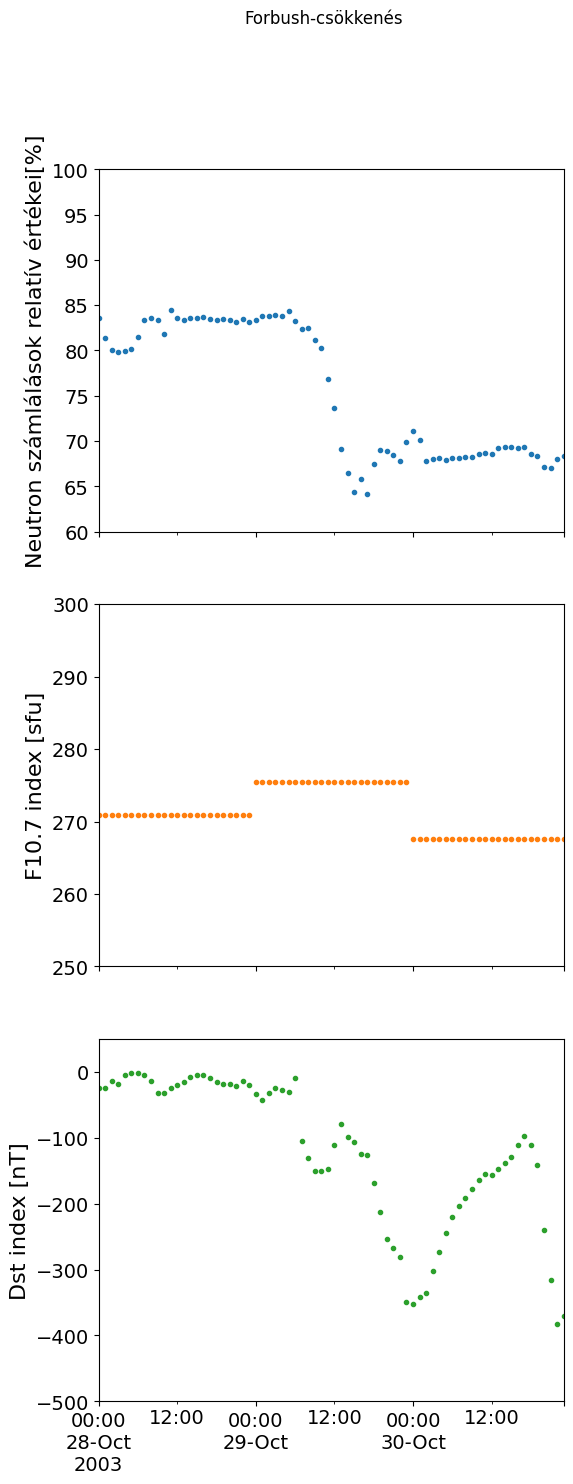

In [ ]:
mdfh.loc["2003-10-28": "2003-10-30"].plot(subplots=True, figsize=(6,16), lw=0, marker='.', markersize=6, legend = False, title='Forbush-csökkenés')

plt.subplot(311)
plt.ylabel('Neutron számlálások relatív értékei[%]', fontsize=16)
plt.ylim(60, 100)
ax=plt.gca()
plt.plot(mdfh.index, mdfh.H_COR, color='gray', label='H_COR data')
ax.tick_params(axis='both', which='both', labelsize=14)

plt.subplot(312)
plt.ylabel('F10.7 index [sfu]', fontsize=16)
plt.ylim(250, 300)
ax=plt.gca()
plt.plot(mdfh.index, mdfh.F10_INDEX, color='gray', label='F10.7 data')
ax.tick_params(axis='both', which='both', labelsize=14)

plt.subplot(313)
plt.ylabel('Dst index [nT]', fontsize=16)
plt.ylim(-500, 50)
ax=plt.gca()
plt.plot(mdfh.index, mdfh.DST, color='gray', label='DST data')
ax.tick_params(axis='both', which='both', labelsize=14)

# just an example of a Forbush decrease
plt.show()

In [ ]:
events = [["1991-03-22", "1991-03-26"], ["1991-10-26", "1991-10-30"], ["1998-11-04", "1998-11-08"], ["2000-07-12", "2000-07-16"], ["2003-10-26", "2003-10-30"], ["2012-03-05", "2012-03-09"]] # all selected timeintervals should come here. They will be combined into a new dataframe
edf = pd.DataFrame()

for event in events:
    edf = pd.concat([edf, mdfh[event[0] : event[1]]])

edf

,H_COR,w,F10_INDEX,DST,nm_avg,f10_avg,dst_avg
1991-03-22 00:00:00,82.514000,,257.700012,-37,87.096332,246.553749,-14.227778
1991-03-22 01:00:00,82.070000,,257.700012,-39,87.084240,246.517499,-14.273611
1991-03-22 02:00:00,82.152000,,257.700012,-37,87.072608,246.481249,-14.318056
1991-03-22 03:00:00,82.472000,,257.700012,-38,87.061832,246.444999,-14.365278
1991-03-22 04:00:00,82.697000,,257.700012,-33,87.051524,246.408749,-14.408333
...,...,...,...,...,...,...,...
2012-03-09 19:00:00,83.954469,,143.500000,-98,94.215899,109.625000,-21.616667
2012-03-09 20:00:00,83.975798,,143.500000,-99,94.199142,109.692916,-21.733333
2012-03-09 21:00:00,83.379764,,143.500000,-95,94.181866,109.760833,-21.847222
2012-03-09 22:00:00,83.656463,,143.500000,-90,94.164495,109.828750,-21.956944


In [ ]:
edf.corr(method='pearson')
p
# fds ["1991-03-21", "1991-03-27"], ["1991-10-25", "1991-10-31"], ["1998-11-05", "1998-11-11"], ["2000-07-13", "2000-07-19"], ["2003-10-26", "2003-11-01"] collection of timeintervals with FDs
# [["1991-03-22", "1991-03-26"], ["1991-10-26", "1991-10-30"], ["1998-11-04", "1998-11-08"], ["2000-07-12", "2000-07-16"], ["2003-10-26", "2003-10-30"]] best correlation results from 4 day periods around FDs
# gles [["1989-09-29", "1989-09-30"], ["2005-05-20", "2005-05-21"], ["2022-06-09", "2022-06-10"]] collection of timeintervals with GLEs
# [["1989-09-26", "1989-10-3"], ["2005-05-17", "2005-05-24"], ["2022-06-06", "2022-06-13"]] 1 week intervals surrounding GLEs (this is not the best correlating timespan)
# tges [["2017-06-10", "2017-06-11"], ["2022-06-09", "2022-06-10"]] collection of timeintervals with TGEs
# [["2017-06-07", "2017-06-14"], ["2022-06-06", "2022-06-13"]] 1 week intervals surrounding TGEs (this is not the best correlating timespan)

<ipython-input-18-5be4027f27fc>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  edf.corr(method='pearson')


NameError: ignored

In [ ]:
# sn.set(rc = {'figure.figsize':(13,5)})
# sn.heatmap(edf.corr(method='pearson').iloc[0:1, 1:3])
# plt.show()

# Correlation of shifted data

In [ ]:
print(mdfh.head())
smdfh = mdfh.copy()
smdfh.DST = smdfh.DST.shift(21) # shift the Dst data backwards
print(smdfh.head())

                      H_COR w   F10_INDEX  DST  nm_avg  f10_avg  dst_avg
1981-12-01 00:00:00  87.268    230.699997    4     NaN      NaN      NaN
1981-12-01 01:00:00  86.924    230.699997    5     NaN      NaN      NaN
1981-12-01 02:00:00  86.867    230.699997    6     NaN      NaN      NaN
1981-12-01 03:00:00  86.408    230.699997    7     NaN      NaN      NaN
1981-12-01 04:00:00  86.523    230.699997    8     NaN      NaN      NaN
                      H_COR w   F10_INDEX  DST  nm_avg  f10_avg  dst_avg
1981-12-01 00:00:00  87.268    230.699997  NaN     NaN      NaN      NaN
1981-12-01 01:00:00  86.924    230.699997  NaN     NaN      NaN      NaN
1981-12-01 02:00:00  86.867    230.699997  NaN     NaN      NaN      NaN
1981-12-01 03:00:00  86.408    230.699997  NaN     NaN      NaN      NaN
1981-12-01 04:00:00  86.523    230.699997  NaN     NaN      NaN      NaN


In [ ]:
smdfh.corr(method='pearson') # correlate the shifted Dst data

NameError: ignored

<ipython-input-20-e959900df431>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = smdfh.corr(method='pearson')
<ipython-input-20-e959900df431>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = smdfh.corr(method='pearson')
<ipython-input-20-e959900df431>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = smdfh.corr(method='pearson')
<ipython-input-20-e959900df431>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future v

0    21
dtype: int64


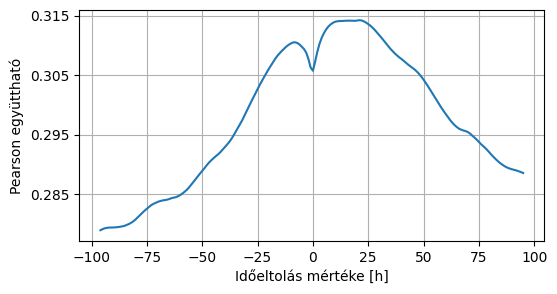

In [ ]:
# test the effect of the timeshift on the correlations for different amounts
shifts = range(-96, 96)
values = pd.DataFrame()

for shift in shifts:
    smdfh = mdfh.copy()
    smdfh.DST = smdfh.DST.shift(shift)
    smdfh.interpolate(method ='linear', limit_direction ='both', inplace=True)
    corr = smdfh.corr(method='pearson')
    values = pd.concat([values, pd.DataFrame([corr[0:1].DST[0]],[shift])])

print(values.idxmax())

values.plot(subplots=True, xlabel = "Időeltolás mértéke [h]", ylabel = "Pearson együttható", yticks=[0.285, 0.295, 0.305, 0.315], figsize=(6,3), legend=False, grid=True, x_compat=True)
plt.show()